In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

from visualization.modules import Normalization
from visualization.style_transfer import *

s

In [2]:
from pathlib import Path
from fastai.basic_train import load_learner

In [3]:
model_path = Path("/home/jupyter/models/")
output_path = Path("home/jupyter/data/style_transfers_2/")

In [4]:
learner = load_learner(path = model_path, file = "vgg19_age_2.pkl")

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
cnn = learner.model[0][0]

In [7]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [8]:
content_img = image_loader("/home/jupyter/data/" + "markus_pp.jpg")
style_img = image_loader("/home/jupyter/data/" + "hendrix.jpg")

style_img = style_img[:, :3, :, :512]
content_img.shape
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))

/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/home/jupyter/vision-playground/nbs/playground/visualization/modules.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


In [10]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
plt.ion()
def imshow(tensor, ax=None, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    if ax is None:
        ax = plt
        title_setter = plt.title
    else:
        title_setter = ax.set_title
    ax.imshow(image)
    ax.axis('off')
    if title is not None:
        title_setter(title)
    #plt.pause(0.001) # pause a bit so that plots are updated


In [ ]:
#encode in strings
#import trained model
#run style transfer with config
#save input, output
#save config as JSON
#callback for 'run style transfer'

#vgg19_age_2.pkl
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = Path("/home/jupyter/models/")
style_img = style_img[:, :3, :, :512]

#product(styles, content)
batch_config = {
    #all relations and tweaking is assumed a cartesian product of params
    "model": "vgg19_age_2.pkl", #TODO: model_meta: information about models trained...
    "loss_func": "",
    "style_content_pairs": [ #can run multiple pair, inputs
        ("/home/jupyter/data/" + "hendrix.jpg", 
         "/home/jupyter/data/" + "markus_pp.jpg"
         )
    ],
    #"optimizer": "LGTB",
    
    #"callback": "...",
    "style_transfer_optim_v": 0.1,
    "style_injects": [[f'conv-{i}' for i in range(15)]],
    "content_injects": [[f'conv-{i}' for i in range(15)]], #doesn't really make a difference
    "epochs": 500,
    "save_every_x_epoch": 50, #non-linear might be better
    "tv_weight": 0.05,
    "output_path":"/home/jupyter/data/style_transfers_2/"
    #just sketching the output file here - not config
    #"outputs": [{"epoch": 100, img_path:"..." }]
}


In [12]:
from datetime import datetime
from pathlib import Path
import json
from PIL import Image

In [13]:
#add %timer to params -- know how long the training took
from numpy import random
def hyperparam_traverse(config, model_path="/home/jupyter/models/", use_noise=False, verbose=True):
    #const {id, name, x} = obj
    outpath = config["output_path"]
    #SETUP ARCH
    learner = load_learner(path = model_path, file = "vgg19_age_2.pkl")
    cnn = learner.model[0][0]
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    
    arch = LayeredModule.from_cnn(cnn, Normalization(cnn_normalization_mean, cnn_normalization_std).to(device))
    #iteration logic later
    style_p, content_p = config["style_content_pairs"][0]
    style_img = image_loader(style_p)
    style_img = style_img[:, :3, :, :512]

    content_img = image_loader(content_p)    

    assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"
    
    #luckily content doesn't vary...
    content_injects = config["content_injects"]
 

    #for loop here over permutations
    for idx, style_inject in enumerate(config["style_injects"]):
        
        style_module = StyleTransferModule(
        arch, 
        content_target=content_img, 
        content_layer_keys=content_injects[0], #TRY AGAIN WITH CONTENT 
        style_target=style_img, 
        style_layer_keys=style_inject)
        
            #TODO try noise instead
         #TODO try noise instead
        if use_noise: 
            input_img = torch.rand(content_img.size()).to(device)
        else:
            input_img = content_img.clone()
        # style_injects = config["style_injects"]
        folder_name = "try"
        for s in style_inject:
            folder_name += "-" + s.split("-")[1]
        folder_name += "/"
        p = Path(outpath + folder_name)
        print(p)
        p.mkdir(parents=True, exist_ok=True)
        conf = config.copy()
        conf['date'] = datetime.now().strftime("%m_%d_%Y, %H:%M:%S")
        conf["outputs"] = []

        conf["style_injects"] = style_inject

        def tap_closure(epoch, img, style_loss, content_loss):                
            if epoch % config["save_every_x_epoch"] != 0: 
                return
            image = img.cpu().clone()  # we clone the tensor to not do changes on it
            image = image.squeeze(0)      # remove the fake batch dimension
            image = unloader(image)
            SL = str(round(style_loss))
            CL = str(round(content_loss))
            print("SL:  ", SL, "CL:  ", CL)
            fname = str(epoch) + "_SL_" + SL + "_CL_" + CL
            conf["outputs"].append({"epoch": epoch, "image": fname, "style_loss": SL, "content_loss": CL})
            image.save(p / fname, 'JPEG')

        #print(str(style_inject))
        output = style_module.run_style_transfer(input_img, num_steps=config["epochs"], tv_weight=config["tv_weight"], callback=tap_closure, verbose=verbose)
    
                     
        #SAVE CONFIG
        meta = "config.json"
        filepath = p / meta
        #json.dump(conf, default=lambda o: o.__dict__, indent=4)
        with open(filepath, 'w') as outfile:
            json.dump(conf, outfile)
    
    plt.figure()
    imshow(output, title='Output Image')
    
    return output
    

In [14]:
#hyperparam_traverse(batch_config)

/home/jupyter/data/style_transfers_2/try-0-1-2-3-4-5-6-7-8-9-10-11-12-13-14
Optimizing...
SL:   4196220 CL:   1626
run [50]:
Style Loss : 20405.880859 Content Loss: 2709.548096

SL:   19545 CL:   2713
run [100]:
Style Loss : 6631.139648 Content Loss: 2727.065186

SL:   6611 CL:   2719
run [150]:
Style Loss : 3514.650391 Content Loss: 2713.566895

SL:   3350 CL:   2719
run [200]:
Style Loss : 2349.438965 Content Loss: 2694.456055

SL:   2034 CL:   2697
run [250]:
Style Loss : 1430.452026 Content Loss: 2687.460205

SL:   1431 CL:   2686
run [300]:
Style Loss : 1139.507812 Content Loss: 2675.584961

SL:   1126 CL:   2672
run [350]:
Style Loss : 969.720398 Content Loss: 2659.508057

SL:   964 CL:   2659
run [400]:
Style Loss : 865.097046 Content Loss: 2648.442383

SL:   863 CL:   2647
run [450]:
Style Loss : 794.928101 Content Loss: 2637.352051

SL:   794 CL:   2637
run [500]:
Style Loss : 739.933350 Content Loss: 2629.041260

SL:   734 CL:   2628
run [550]:
Style Loss : 699.290039 Content

tensor([[[[0.6255, 0.5195, 0.5825,  ..., 0.5956, 0.5948, 0.5924],
          [0.6262, 0.5197, 0.5859,  ..., 0.5943, 0.5919, 0.5946],
          [0.6079, 0.5272, 0.5886,  ..., 0.5905, 0.5922, 0.5925],
          ...,
          [0.1768, 0.1784, 0.1826,  ..., 0.0741, 0.0881, 0.0914],
          [0.1762, 0.1762, 0.1770,  ..., 0.0734, 0.0887, 0.0912],
          [0.1647, 0.1643, 0.1700,  ..., 0.0749, 0.0834, 0.0887]],

         [[0.3053, 0.3058, 0.3243,  ..., 0.5794, 0.5872, 0.5892],
          [0.3051, 0.3036, 0.3452,  ..., 0.5788, 0.5843, 0.6073],
          [0.3022, 0.3011, 0.3416,  ..., 0.5778, 0.5831, 0.6055],
          ...,
          [0.6956, 0.6967, 0.6937,  ..., 0.1236, 0.1189, 0.1416],
          [0.6959, 0.6963, 0.6955,  ..., 0.2489, 0.2510, 0.2497],
          [0.6976, 0.6971, 0.6975,  ..., 0.2491, 0.2549, 0.2546]],

         [[0.5941, 0.5977, 0.6015,  ..., 0.6275, 0.6370, 0.6373],
          [0.5941, 0.5985, 0.6030,  ..., 0.5769, 0.5769, 0.5783],
          [0.5952, 0.5976, 0.6028,  ..., 0

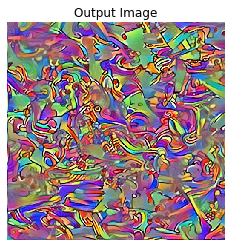

In [15]:
hyperparam_traverse(batch_config, use_noise=True)

In [16]:
from itertools import product, chain, combinations, permutations

In [17]:
from random import sample 
conv_layer_indices = list(range(0, 16))

In [18]:
str(['conv-1', 'conv-3', 'conv-6', 'conv-9', 'conv-14', 'conv-15'])

"['conv-1', 'conv-3', 'conv-6', 'conv-9', 'conv-14', 'conv-15']"

In [19]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

layer_combos =  [list(subs) for subs in powerset(conv_layer_indices) if subs != ()]

In [20]:

samp = sample(layer_combos,k=1000)
samp_layers = [
    [f'conv-{i}' for i in subsamp]
    for subsamp in samp]
samp_layers[:3]

[['conv-0',
  'conv-1',
  'conv-3',
  'conv-6',
  'conv-7',
  'conv-8',
  'conv-9',
  'conv-10',
  'conv-11',
  'conv-12'],
 ['conv-1',
  'conv-4',
  'conv-6',
  'conv-7',
  'conv-8',
  'conv-11',
  'conv-13',
  'conv-14',
  'conv-15'],
 ['conv-0',
  'conv-2',
  'conv-3',
  'conv-5',
  'conv-6',
  'conv-7',
  'conv-8',
  'conv-10',
  'conv-11',
  'conv-13']]

In [ ]:
bc = batch_config.copy()
samp
bc["style_injects"] = samp_layers
hyperparam_traverse(bc, verbose=False)

/home/jupyter/data/style_transfers_2/try-0-1-3-6-7-8-9-10-11-12
Optimizing...
SL:   2427542 CL:   0
SL:   20029 CL:   2244
SL:   20648 CL:   2548
SL:   5184 CL:   2474
SL:   2595 CL:   2442
SL:   1592 CL:   2406
SL:   1235 CL:   2383
SL:   1082 CL:   2366
SL:   967 CL:   2350
SL:   897 CL:   2340
SL:   27615 CL:   2516
SL:   991 CL:   2337
SL:   759 CL:   2326
SL:   702 CL:   2312
SL:   1482 CL:   2278
/home/jupyter/data/style_transfers_2/try-1-4-6-7-8-11-13-14-15
Optimizing...
SL:   2160866 CL:   0
SL:   21442 CL:   2077
SL:   4598 CL:   2172
SL:   2260 CL:   2179
SL:   1543 CL:   2169
SL:   1308 CL:   2150
SL:   4758872 CL:   3926
SL:   11805 CL:   2389
SL:   3120 CL:   2346
SL:   1428 CL:   2320
SL:   1051 CL:   2296
